In [4]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd

from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


2023-11-30 21:16:05.630601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
RED = 0
GREEN = 1
BLUE = 2

dataset_path = './sign_data/'

In [6]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path(dataset_path + "data/train_features.parquet")
meta_file = Path(dataset_path + "data/meta_full.parquet")

dft = pl.read_parquet(features_file, use_pyarrow=True, memory_map=True)
dfm = pl.read_parquet(meta_file, use_pyarrow=True, memory_map=True)
dft = dft.join(dfm, on="ClassId")
# del dfm

In [7]:
# To do: select 200 random images from each class
features = dft.filter(
    pl.int_range(0, pl.count()).shuffle().over("ClassId") < 200
)


In [8]:
# Test distribution:
features.groupby("ClassId").agg(pl.count())

ClassId,count
i64,u32
6,200
5,200
18,200
35,200
24,200
37,200
38,200
31,200
17,200


In [17]:
columns = ['ClassId', 'Hue_Hist', 'Saturation_Hist', 'Value_Hist', 'LBP_Hist', 'HOG_Features']
features = features[columns]


In [18]:
features.head(3)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Hist,HOG_Features
i64,list[i64],list[i64],list[i64],list[i64],list[f32]
20,"[247, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]","[127, 95, … 760]","[0.318327, 0.160083, … 0.28708]"
20,"[250, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]","[124, 81, … 816]","[0.295379, 0.246268, … 0.106746]"
20,"[232, 0, … 0]","[22, 0, … 0]","[0, 0, … 0]","[148, 91, … 893]","[0.356871, 0.0, … 0.017861]"


In [61]:
def build_model(num_features, learning_rate=.001):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(
        units=43,                     # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We'll use SGD
    # We will specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. This finalizes the graph for training.
    # We specify the MSE loss.
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [70]:
# Run base model per feature (excluding pattern matching)
# Using Train sample (200 images per class)
NUM_BATCH = 32
EPSILON = 0.0001
EPOCHS = 50
SPLIT = 0.10

models = []

for col in columns[1:]:
    train_features, labels = features[col], features['ClassId']
    split = int(train_features.shape[0] * SPLIT)
    val_features, v_labels = train_features[-split:], labels[-split:]
    train_features, t_labels = train_features[:-split], labels[:-split]
   
    tdataset = tf.data.Dataset.from_tensors(((np.vstack(train_features)), t_labels))
    vdataset = tf.data.Dataset.from_tensors(((np.vstack(val_features)), v_labels))
    
    tdataset.batch(NUM_BATCH)
    
    learningRate = 0.1 if col == 'HOG_Features' else EPSILON
    learningRate = 0.01 if col == 'LBP_Hist' else learningRate
    epochs = 10 if col == 'LBP_Hist' else EPOCHS
    
    print(f'Model for {col}')
    print('='*100)
    num_features = train_features[0].len()
    model = build_model(num_features, learningRate)
    
    history = model.fit(tdataset, epochs=epochs, verbose=1, validation_data=vdataset)
    models.append((model, history, col, learningRate))
    print('='*100, '\n\n')


Model for Hue_Hist
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 16631417.0000

2023-12-01 07:54:42.398415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-01 07:54:42.596615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 247ms/step - loss: 16631417.0000 - val_loss: 1689059.6250
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 2322593.2500 - val_loss: 944919.9375
Epoch 3/50
1/1 [==============================] - 0s 13ms/step - loss: 773035.0000 - val_loss: 761389.1250
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 523970.3125 - val_loss: 682162.8750
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 429031.3438 - val_loss: 619642.4375
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 366647.8438 - val_loss: 562715.2500
Epoch 7/50
1/1 [==============================] - 0s 19ms/step - loss: 319488.0312 - val_loss: 513254.3125
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 282322.4375 - val_loss: 469661.0938
Epoch 9/50
1/1 [==============================] - 0s 18ms/step - loss: 252274.6250 - val_loss: 431260.6562
Epoch 10/50
1/1 [==========================

2023-12-01 07:54:43.896559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-01 07:54:44.085988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 257ms/step - loss: 16631417.0000 - val_loss: 4488264.5000
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 4345539.5000 - val_loss: 1693849.2500
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 1403605.3750 - val_loss: 1025241.3125
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 674572.9375 - val_loss: 840796.8125
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 472983.2188 - val_loss: 763759.2500
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 399684.4062 - val_loss: 710296.2500
Epoch 7/50
1/1 [==============================] - 0s 41ms/step - loss: 359613.0312 - val_loss: 662955.6250
Epoch 8/50
1/1 [==============================] - 0s 17ms/step - loss: 329754.8125 - val_loss: 618626.5000
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 304272.2812 - val_loss: 576955.2500
Epoch 10/50
1/1 [=======================

2023-12-01 07:54:45.824417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-01 07:54:46.012193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 241ms/step - loss: 16631417.0000 - val_loss: 4338997.5000
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 4577559.5000 - val_loss: 2045287.1250
Epoch 3/50
1/1 [==============================] - 0s 19ms/step - loss: 2190824.2500 - val_loss: 1218947.3750
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 1284704.7500 - val_loss: 869929.3125
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 884298.3750 - val_loss: 689332.0000
Epoch 6/50
1/1 [==============================] - 0s 19ms/step - loss: 673920.1250 - val_loss: 575646.6875
Epoch 7/50
1/1 [==============================] - 0s 21ms/step - loss: 543877.2500 - val_loss: 493862.9688
Epoch 8/50
1/1 [==============================] - 0s 20ms/step - loss: 453451.7812 - val_loss: 430636.8125
Epoch 9/50
1/1 [==============================] - 0s 25ms/step - loss: 385856.7188 - val_loss: 379957.0625
Epoch 10/50
1/1 [======================

2023-12-01 07:54:47.370936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-01 07:54:47.530212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 212ms/step - loss: 16631417.0000 - val_loss: 15990429581312.0000
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 18090488233984.0000 - val_loss: 17637359479643176960.0000
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 20061269146959085568.0000 - val_loss: 19554650911090528858669056.0000
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 22247499693441621562490880.0000 - val_loss: 21685428463605428312652503842816.0000
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 24671982986897800518430135156736.0000 - val_loss: inf
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: inf - val_loss: inf
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: inf - val_loss: inf
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: inf - val_loss: inf
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: inf

2023-12-01 07:54:48.210999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 249ms/step - loss: 86525.5781 - val_loss: 49329.9023
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 55604.9648 - val_loss: 31128.9980
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: 35793.3320 - val_loss: 19588.0840
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 23098.6055 - val_loss: 12288.7842
Epoch 5/50
1/1 [==============================] - 0s 33ms/step - loss: 14963.3330 - val_loss: 7687.0508
Epoch 6/50


2023-12-01 07:54:48.418360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 34ms/step - loss: 9749.1133 - val_loss: 4797.8496
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 6406.3213 - val_loss: 2993.4075
Epoch 8/50
1/1 [==============================] - 0s 32ms/step - loss: 4262.5288 - val_loss: 1874.1257
Epoch 9/50
1/1 [==============================] - 0s 32ms/step - loss: 2886.9436 - val_loss: 1186.0471
Epoch 10/50
1/1 [==============================] - 0s 32ms/step - loss: 2003.5820 - val_loss: 768.0872
Epoch 11/50
1/1 [==============================] - 0s 32ms/step - loss: 1435.6337 - val_loss: 518.3224
Epoch 12/50
1/1 [==============================] - 0s 32ms/step - loss: 1069.8224 - val_loss: 372.4656
Epoch 13/50
1/1 [==============================] - 0s 32ms/step - loss: 833.5754 - val_loss: 290.1288
Epoch 14/50
1/1 [==============================] - 0s 32ms/step - loss: 680.3958 - val_loss: 246.0703
Epoch 15/50
1/1 [==============================] - 0s 33ms/step - loss: 580.4920 - val

In [34]:
def plot_loss(model, history, title, pos):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)   
    history = history[np.isfinite(history).all(1)]

    plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.title(title)
    plt.show()

    # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])
#     print('Final weights:', model.layers[0].get_weights())

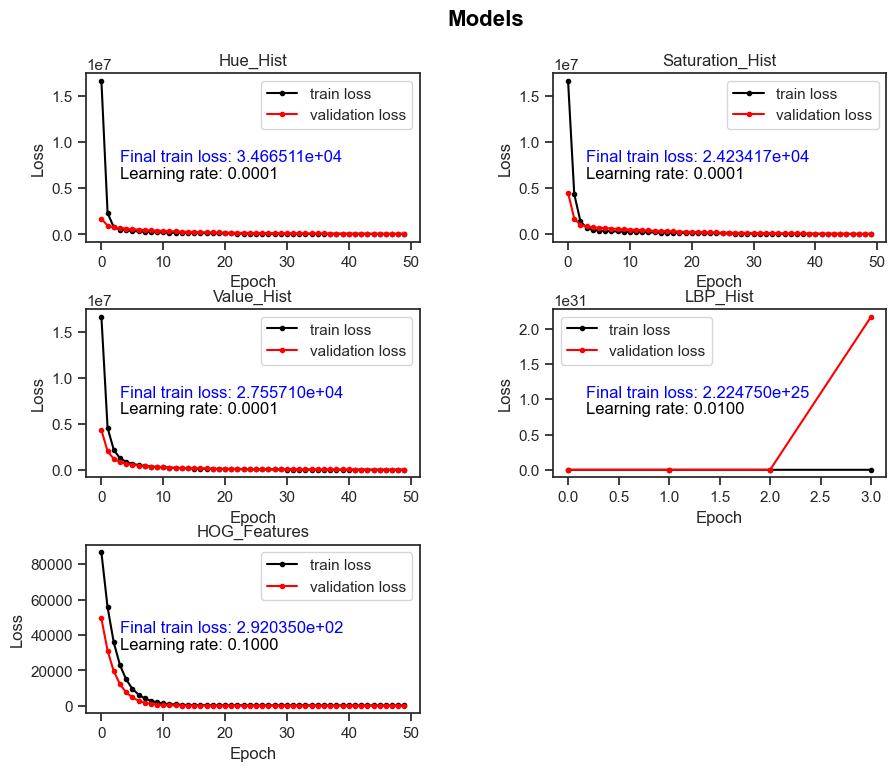

In [71]:
plt.figure(figsize=(10,8))
plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")

for i,m in enumerate(models):
    hist = pd.DataFrame(m[1].history)   
    hist = hist[np.isfinite(hist).all(1)]
    
    ax = plt.subplot(3, 2, i+1)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(hist)), hist['loss'], marker='.', color='black')
    plt.plot(range(len(hist)), hist['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.title(m[2])
    
    loss = "Final train loss: {lo:e}"
    loss = loss.format(lo=list(hist['loss'])[-1])

    lrate = "Learning rate: {ep:.4f}"
    lrate = lrate.format(ep=m[3])

    plt.text(0.1, 0.55, loss,
             ha='left', va='top',
             transform=ax.transAxes,
             color='blue'
            )
    plt.text(0.1, 0.45, lrate,
             ha='left', va='top',
             transform=ax.transAxes,
             color='black'
            )

    
plt.subplots_adjust(left=0.1, 
                bottom=0.1,  
                right=0.9,  
                top=0.9,  
                wspace=0.4,  
                hspace=0.4) 
    
plt.show()


In [57]:
hist = pd.DataFrame(models[0][1].history)
hist.tail(5)

,loss,val_loss
45,38029.929688,71974.492188
46,37125.664062,70195.234375
47,36265.605469,68506.859375
48,35446.421875,66902.781250
49,34665.113281,65376.976562


In [75]:
models[4][0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                125431    
                                                                 
Total params: 125,431
Trainable params: 125,431
Non-trainable params: 0
_________________________________________________________________
